# Проект: классификация

In [1]:
import numpy as np
import pandas as pd
rng = np.random.default_rng(seed=123456)
np.set_printoptions(suppress=True, precision=4, linewidth=100)
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_colwidth = 40

from sklearn import preprocessing 
from sklearn.feature_selection import SelectKBest, RFE, f_classif
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import compose
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import pipeline
from sklearn import metrics
import optuna

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

In [2]:
def top_unique_values(df, topvals=5, dropna=True):
    max_width = pd.get_option("display.max_colwidth") - 10
    col_names = ['Unique values'] + ['Top ' + str(num) for num in range(1, topvals + 1)] + ['Other']
    df_out = pd.DataFrame(columns=col_names)
    cols = df.columns
    for col in cols:
        top_values = pd.DataFrame(df[col].value_counts(dropna=dropna, normalize=True)).iloc[0:topvals]
        lst = []
        lst.append(df[col].nunique(dropna=dropna))
        for r in top_values.itertuples():
            i = str(r[0])[0:max_width] + ' (' + str(f'{r[1]:.1%}') + ')'
            lst.append(i)
        while len(lst) <= topvals:
            lst.append('\u2013')
        remainder = 1 - top_values[col].sum()
        if remainder != 0:
            lst.append(str(f'{remainder:.1%}'))
        else:
            lst.append('\u2013')
        row = (col, lst)
        df_out = pd.concat(
            [df_out, pd.DataFrame.from_dict(dict([row]), orient='index', columns=col_names)], 
            axis=0
        )
    return df_out

def iqr_outliers(df):
    vars = df.select_dtypes(np.number).columns
    df_out = df[vars].agg(
                lambda x: [
                    np.min(x), 
                    np.nanpercentile(x, 25), 
                    np.nanmean(x), 
                    np.nanmedian(x),
                    np.nanpercentile(x, 75), 
                    np.max(x),
                    np.nanstd(x)
                ])
    df_out.index = ['min', 'Q1', 'mean', 'median', 'Q3', 'max', 'std']
    df_out = df_out.transpose()
    
    lst = []
    for idx in df_out.index:
        row = (np.sum(df[idx] < df_out.loc[idx, 'Q1'] 
                      - 1.5 * (df_out.loc[idx, 'Q3'] - df_out.loc[idx, 'Q1'])),
               np.sum(df[idx] > df_out.loc[idx, 'Q3'] 
                      + 1.5 * (df_out.loc[idx, 'Q3'] - df_out.loc[idx, 'Q1']))
            )
        lst.append(row)
    outliers = pd.DataFrame(
        lst, 
        columns=['Values < 1.5IQR', 'Values > 1.5IQR'], 
        index=vars
    )
    df_out = (pd.concat([df_out, outliers], axis=1))
    return df_out

Вам предоставили данные о последней маркетинговой кампании, которую проводил банк: задачей было привлечь клиентов для открытия депозита. Вы должны проанализировать эти данные, выявить закономерность и найти решающие факторы, повлиявшие на то, что клиент вложил деньги именно в этот банк. Если вы сможете это сделать, то поднимете доходы банка и поможете понять целевую аудиторию, которую необходимо привлекать путём рекламы и различных предложений.

**Бизнес-задача**: определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

**Техническая задача** для вас как для специалиста в Data Science: построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

**Описание признаков:**

*Данные о клиентах банка:*

| Variable | Description |
|---|---|
|age|возраст|
|job|сфера занятости|
|marital|семейное положение|
|education|уровень образования|
|default|имеется ли просроченный кредит|
|housing|имеется ли кредит на жильё|
|loan|имеется ли кредит на личные нужды|
|balance|баланс денежных средств|

*Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:*

| Variable|Description|
|---|---|
|contact| тип контакта с клиентом|
|month|месяц, в котором был последний контакт|
|day|день, в который был последний контакт|
|duration|продолжительность контакта в секундах|

*Прочие признаки:*

| Variable | Description |
|---|---|
|campaign|количество контактов с этим клиентом в течение текущей кампании|
|pdays|количество дней, прощедщих с момента последнего контакта в предыдущей маркетинговой кампании|
|previous|количество контактов до текущей кампании|
|poutcome|результат прошлой маркетинговой кампании|

Целевая переменная **deposit** определяет, согласится ли клиент открыть депозит в банке.

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

In [3]:
df = pd.read_csv('data/bank_fin.zip', sep=';')
pd.concat([df.head(3), df.tail(3)])

age         job  marital  education default       balance housing loan  \
0       59      admin.  married  secondary      no   2 343,00 $      yes   no   
1       56      admin.  married  secondary      no      45,00 $       no   no   
2       41  technician  married  secondary      no   1 270,00 $      yes   no   
11159   32  technician   single  secondary      no      29,00 $       no   no   
11160   43  technician  married  secondary      no         0  $       no  yes   
11161   34  technician  married  secondary      no         0  $       no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
0       unknown    5   may      1042         1     -1         0  unknown   
1       unknown    5   may      1467         1     -1         0  unknown   
2       unknown    5   may      1389         1     -1         0  unknown   
11159  cellular   19   aug       156         2     -1         0  unknown   
11160  cellular    8   may         9         2    172         5  failure   
11161  cellular    9   jul       628         1     -1         0  unknown   

      deposit  
0         yes  
1         yes  
2         yes  
11159      no  
11160      no  
11161      no

In [4]:
top_unique_values(df)

Unique values               Top 1                Top 2  \
age                  76           31 (4.4%)            32 (4.3%)   
job                  12  management (23.0%)  blue-collar (17.4%)   
marital               3     married (56.9%)       single (31.5%)   
education             4   secondary (49.1%)     tertiary (33.0%)   
default               2          no (98.5%)           yes (1.5%)   
balance            3802        0  $  (6.9%)       1,00 $  (0.4%)   
housing               2          no (52.7%)          yes (47.3%)   
loan                  2          no (86.9%)          yes (13.1%)   
contact               3    cellular (72.0%)      unknown (21.0%)   
day                  31           20 (5.1%)            18 (4.9%)   
month                12         may (25.3%)          aug (13.6%)   
duration           1428           97 (0.3%)           161 (0.3%)   
campaign             36           1 (43.0%)            2 (27.1%)   
pdays               472          -1 (74.6%)            92 (0.9%)   
previous             34           0 (74.6%)             1 (7.9%)   
poutcome              4     unknown (74.6%)      failure (11.0%)   
deposit               2          no (52.6%)          yes (47.4%)   

                        Top 3            Top 4            Top 5  Other  
age                 34 (4.2%)        33 (4.2%)        35 (4.1%)  78.8%  
job        technician (16.3%)   admin. (12.0%)  services (8.3%)  23.0%  
marital      divorced (11.6%)                –                –   0.0%  
education     primary (13.4%)   unknown (4.5%)                –      –  
default                     –                –                –      –  
balance        3,00 $  (0.3%)   2,00 $  (0.3%)   4,00 $  (0.3%)  91.8%  
housing                     –                –                –      –  
loan                        –                –                –      –  
contact      telephone (6.9%)                –                –      –  
day                 30 (4.3%)         5 (4.3%)        15 (4.2%)  77.3%  
month             jul (13.6%)      jun (10.9%)       nov (8.4%)  28.1%  
duration           158 (0.3%)       119 (0.3%)       150 (0.3%)  98.3%  
campaign            3 (11.8%)         4 (6.9%)         5 (3.4%)   7.8%  
pdays              182 (0.8%)        91 (0.8%)       181 (0.7%)  22.2%  
previous             2 (6.2%)         3 (3.9%)         4 (2.2%)   5.2%  
poutcome       success (9.6%)     other (4.8%)                –      –  
deposit                     –                –                –      –

**Задание 2.1**  
В каком признаке пропущенных значений больше всего?
* Название признака
* Количество пропусков в признаке

In [5]:
pd.DataFrame({
    'dtype': df.dtypes, 
    'obs': df.count(), 
    'nulls': df.isna().sum()
    })

dtype    obs  nulls
age         int64  11162      0
job        object  11162      0
marital    object  11162      0
education  object  11162      0
default    object  11162      0
balance    object  11137     25
housing    object  11162      0
loan       object  11162      0
contact    object  11162      0
day         int64  11162      0
month      object  11162      0
duration    int64  11162      0
campaign    int64  11162      0
pdays       int64  11162      0
previous    int64  11162      0
poutcome   object  11162      0
deposit    object  11162      0

**Задание 2.2**  
Вы успешно справились с предыдущим заданием и выяснили количество пропущенных значений. Однако в настоящих данных обычно всё не так просто, и пропущенные (неизвестные) значения могут присутствовать неявным образом. Это значит, что они могут быть закодированы каким-то словом или набором символов. Часто это не является проблемой, но это необходимо выявить. В наших данных именно такая ситуация (например, в признаке со сферой занятости). Узнайте, каким именно словом закодированы пропущенные (неизвестные) значения.

Введите слово, которым закодированы пропуски (неизвестные значения).

In [6]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

**Задание 2.3**  
Мы нашли пропущенные значения, и хотелось бы теперь их обработать. Однако мы не можем этого сделать, так как не все данные представлены в корректном виде.

Обратите внимание на признак balance: в данных содержится лишняя запятая и знак доллара. По этой причине этот признак не считывается как число. Обработайте данные этого признака так, чтобы он был преобразован в тип float.

Вычислите среднее значение по преобразованному в корректный вид признаку balance. Ответ округлите до трёх знаков после точки-разделителя.

In [7]:
df['balance'] = (df['balance'].apply(
    lambda x: 
        x.strip()
        .replace(',00 $', '')
        .replace('0  $', '0')
        .replace(' ', '')
    if isinstance(x, str) else x)
    .replace('', np.nan)
    .astype('float')
)

np.round(df['balance'].mean(), 3)

1529.129

**Задание 2.4**  
Итак, значения в признаке balance приобрели нормальный вид, и теперь мы можем обработать пропуски, которые в нём присутствуют. Конечно, пропуски можно было бы просто удалить, но мы поступим по-другому: заменим пропуски на медианное значение по этому признаку.

Вычислите среднее значение по преобразованному в корректный вид признаку balance. Ответ округлите до трёх знаков после точки-разделителя.


In [8]:
%%capture
df['balance'].loc[df['balance'].isna()] = df['balance'].median()

In [9]:
np.round(df['balance'].mean(), 3)

1526.936

**Задание 2.5**  
Ранее мы выяснили, что в признаке job есть пропущенные значения, которые не отображаются как пропуски в явном виде. Однако нам всё равно важно их обработать. Мы знаем, что для категориальных признаков пропущенные значения заменяются модой по данному признаку.

Замените все пропущенные значения в признаке job на модальные. То же самое сделайте с признаком, отвечающим за уровень образования.

После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). Ответ округлите до трёх знаков после точки-разделителя.

In [10]:
df.loc[df['job'] == 'unknown', 'job'] = df['job'].mode()[0]

df['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [11]:
df.loc[df['education'] == 'unknown', 'education'] = df['education'].mode()[0]

np.round(df.loc[(df['job'] == df['job'].mode()[0]) 
    & (df['education'] == df['education'].mode()[0]), 'balance'].mean(), 3
)

1598.883

**Задание 2.6**  
Изучите признак, отображающий баланс клиентов, на предмет выбросов.

В математической статистике есть несколько подходов, позволяющих определить наличие выбросов. Мы будем считать, что выбросы находятся за пределами отрезка, нижняя граница которого определяется как нижний квартиль, из которого вычли полтора межквартильных размаха ($Q1 - 1,5 * IQR$) , а верхняя граница — как верхний квартиль, к которому прибавили полтора межквартильных размаха ($Q3 + 1,5 * IQR$). Найдите эти границы, и отфильтруйте значения так, чтобы выбросов в данных не осталось.

Введите верхнюю и нижнюю границы поиска выбросов по методу Тьюки, округлив их до целых чисел.
* Нижняя граница
* Верхняя граница

In [12]:
outliers = iqr_outliers(df)
iqr_lower_bound = (outliers.loc['balance', 'Q1'] 
                    - 1.5*(outliers.loc['balance', 'Q3'] - outliers.loc['balance', 'Q1']))
iqr_upper_bound = (outliers.loc['balance', 'Q3'] 
                    + 1.5*(outliers.loc['balance', 'Q3'] - outliers.loc['balance', 'Q1']))

df = df.drop(
    index=df.query('`balance` < @iqr_lower_bound | `balance` > @iqr_upper_bound').index)
print(df.shape, iqr_lower_bound, iqr_upper_bound, sep='\n')

(10105, 17)
-2241.0
4063.0


## Часть 2:  Разведывательный анализ

**Задание 3.1**  
Давайте изучим распределение целевой переменной: есть ли несбалансированность классов? Чтобы это определить, вычислите частоты для открывших депозит и для тех, кто его не открыл. Сопроводите числа диаграммой, отражающей полученные результаты.

Сколько клиентов открыли депозит?

In [13]:
df['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

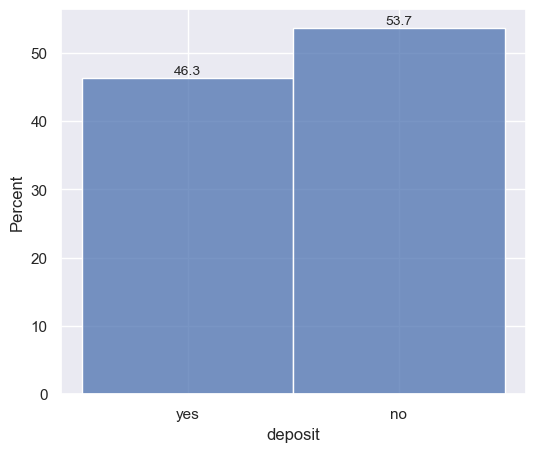

In [14]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.histplot(data=df, x=df['deposit'], stat='percent', ax=ax)

for i in range(df['deposit'].unique().size):
    ax.text(x=i, 
            y=1.01*[p.get_height() for p in ax.patches][i], 
            s=f'{[p.get_height() for p in ax.patches][i]:.1f}',
            fontsize='small', 
            ha='center'
    );

Начнём с описательных статистик для количественных переменных.
* Рассчитайте их и продумайте подробную интерпретацию.
* Попробуйте описать данные, которые у вас есть, увидеть первые зависимости.
* Рассмотрите минимальные и максимальные значения.
* Посмотрите на меры разброса и оцените, насколько данные вариативны.
* Сравнив меры центральной тенденции, сделайте выводы о том, есть ли аномальные значения с меньшей или большей стороны.
* Дополните выводы визуализациями. Вспомните, какие диаграммы могут помочь в иллюстрации распределений количественных данных.

**Задание 3.2**  
Каков максимальный возраст клиента банка?

**Задание 3.3**  
Какова минимальная продолжительность разговора с клиентом банка? Ответ дайте в количестве секунд.

In [15]:
iqr_outliers(df)

min       Q1     mean   median         Q3        max  \
age          18.0000  32.0000  40.8955  38.0000    48.0000    95.0000   
balance  -2,049.0000  95.0000 807.6535 445.0000 1,227.0000 4,063.0000   
day           1.0000   8.0000  15.5903  15.0000    22.0000    31.0000   
duration      2.0000 137.0000 368.7426 252.0000   490.0000 3,881.0000   
campaign      1.0000   1.0000   2.5172   2.0000     3.0000    43.0000   
pdays        -1.0000  -1.0000  51.3196  -1.0000     2.0000   854.0000   
previous      0.0000   0.0000   0.8162   0.0000     1.0000    58.0000   

              std  Values < 1.5IQR  Values > 1.5IQR  
age       11.7343                0              174  
balance  994.1028                5              581  
day        8.4411                0                0  
duration 346.6344                0              591  
campaign   2.7070                0              551  
pdays    109.6388                0             2515  
previous   2.2437                0             1129

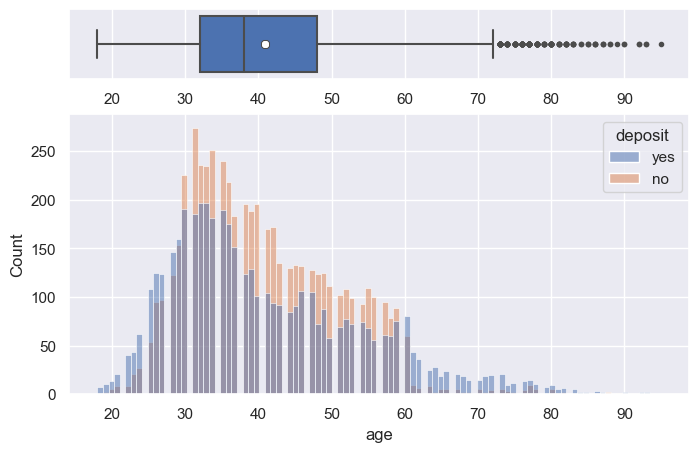

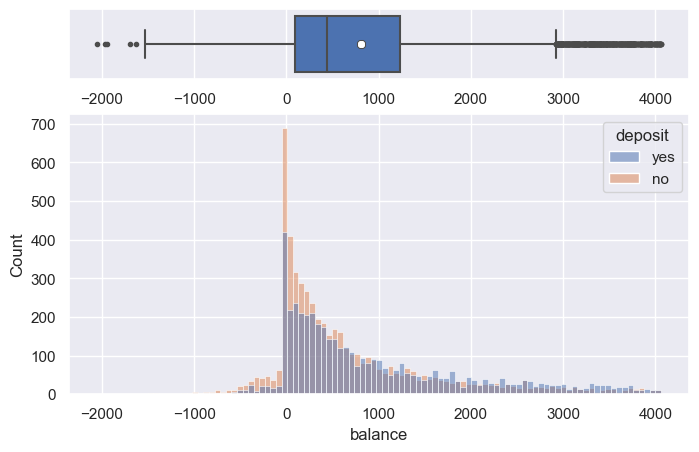

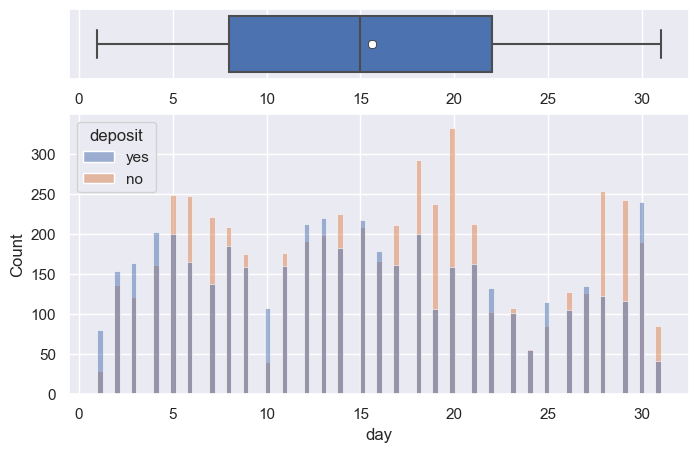

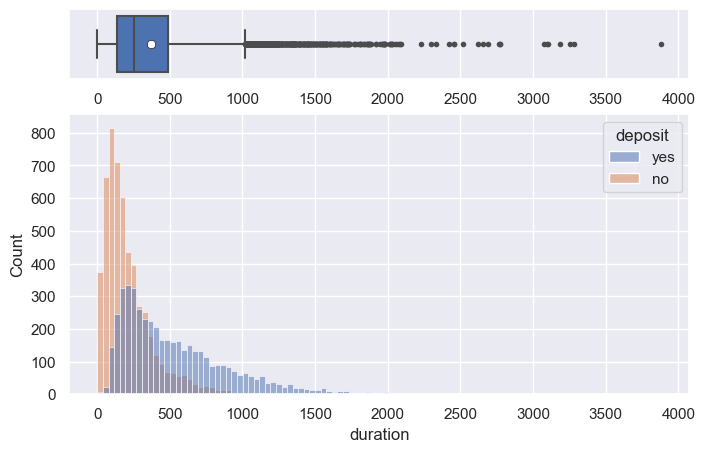

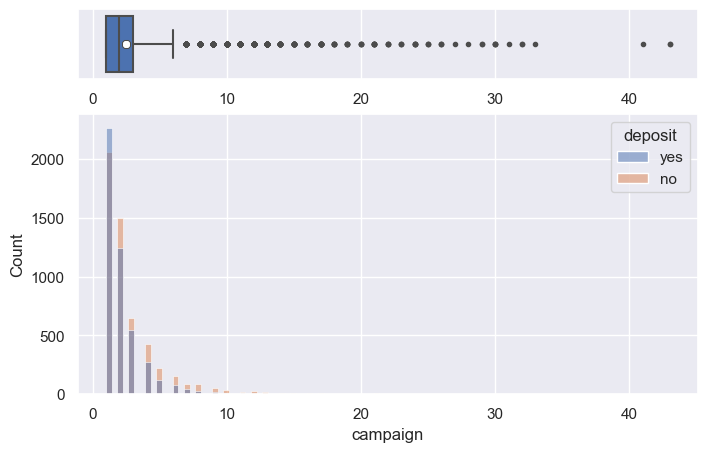

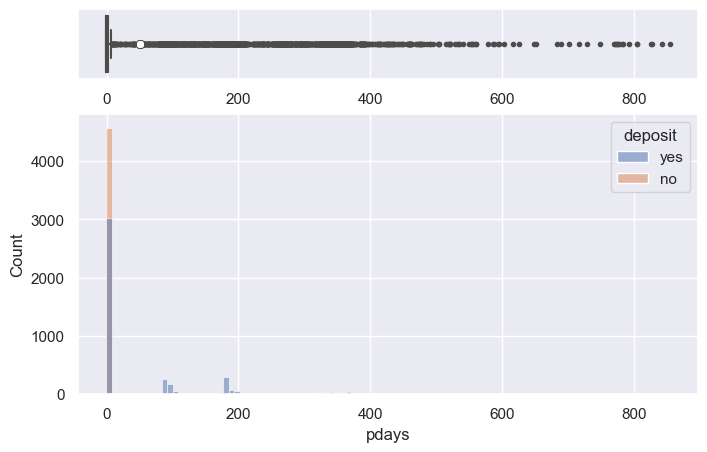

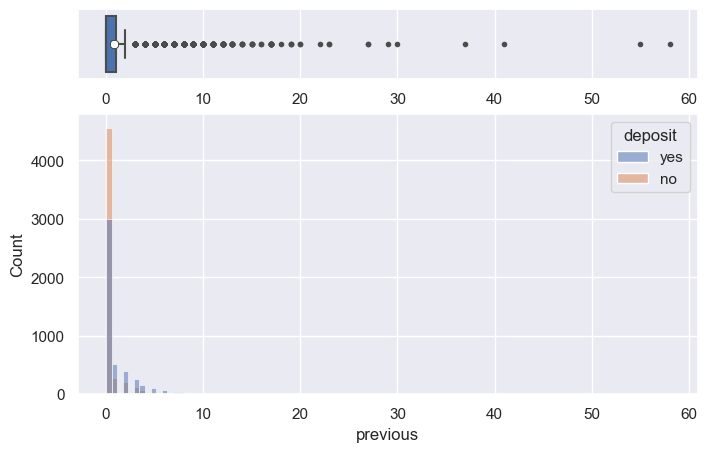

In [16]:
for col in outliers.index:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5), 
                                    gridspec_kw={"height_ratios": (0.2, 0.8)})
    sns.boxplot(x=df[col].dropna(), 
        saturation=0.1, 
        showmeans=True, 
        width=0.8, 
        fliersize=6,
        boxprops={'facecolor': 'C0', 'edgecolor': '#4C4D4E', 'linewidth': 1.5},
        flierprops={"marker": "."},
        meanprops={'marker': '8', 'markerfacecolor': 'w', 'markeredgecolor': '#4C4D4E', 'markeredgewidth':0.75},
        ax=ax1
    )
    sns.histplot(x=df[col].dropna(), hue=df['deposit'], bins='sqrt', ax=ax2)
    ax1.set_xlabel(None)
    ax2.set_xlabel(col)


Теперь давайте рассмотрим описательные статистики для категориальных переменных.

Попробуйте извлечь максимум информации из тех показателей, которые можете получить. Сколько всего сфер занятости представлено среди клиентов банка? В каждый ли месяц проходила маркетинговая кампания? Какое семейное положение встречается чаще всего? А образование? Постарайтесь дать достаточно подробную интерпретацию. Для лучшей наглядности добавьте визуализации по каждой категориальной переменной.

**Задание 3.4**  
Сколько было месяцев, в которых проводилась маркетинговая кампания?

**Задание 3.5**  
Сколько сфер занятости представлено среди клиентов банка?

In [17]:
df.loc[df['campaign'] > 0, 'month'].unique().shape

(12,)

In [18]:
df['job'].unique().shape

(11,)

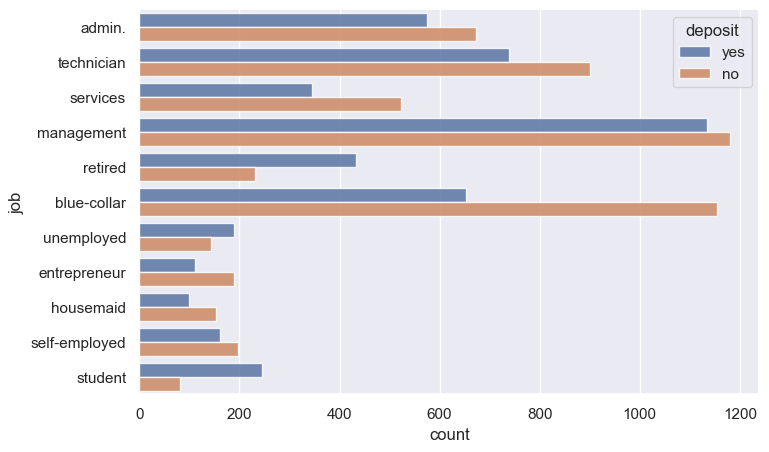

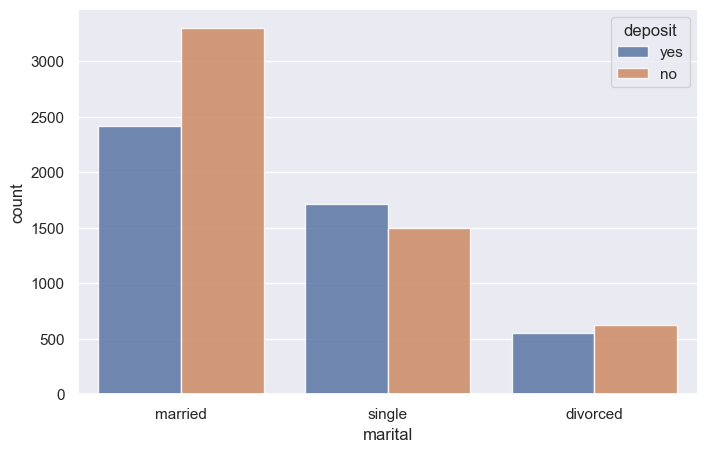

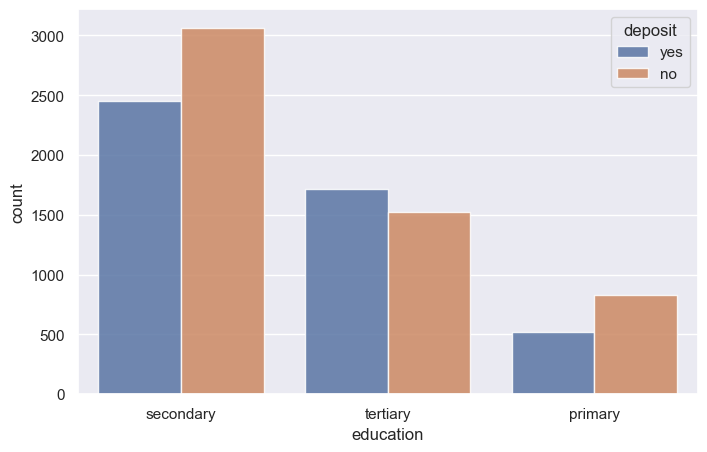

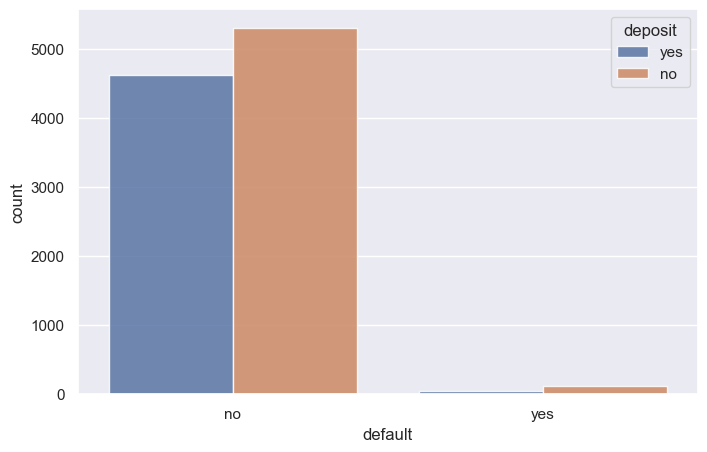

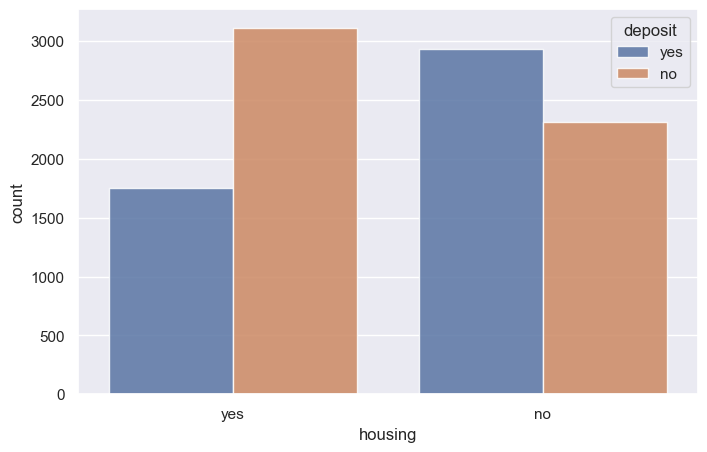

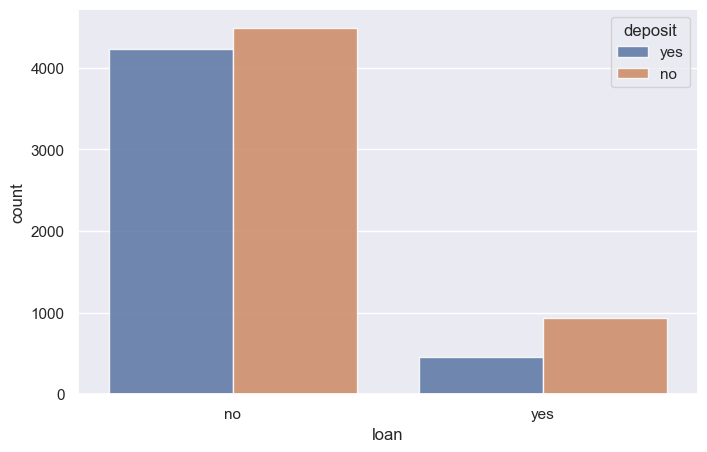

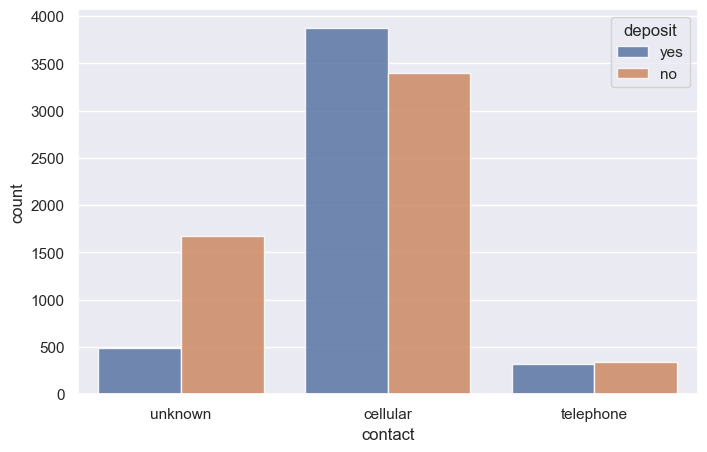

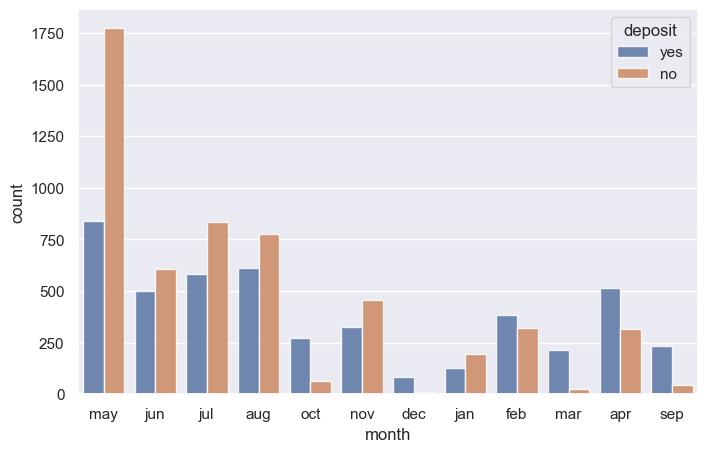

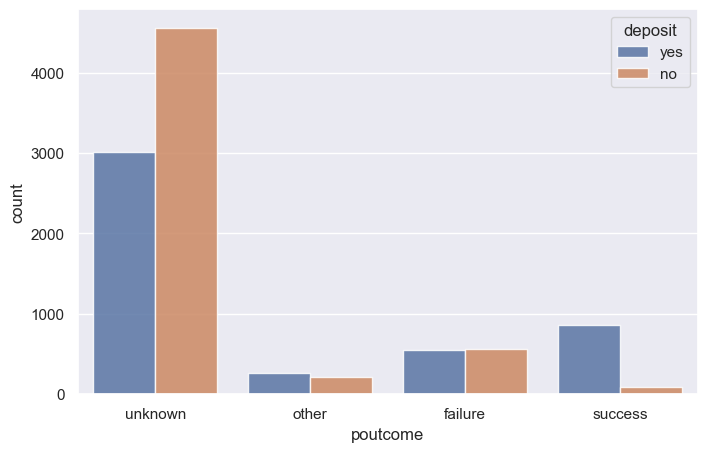

In [19]:
for col in df.select_dtypes('object').columns[:-1]:
    fig, ax = plt.subplots(figsize=(8, 5), )
    if col=='job':
        sns.countplot(data=df, y=df[col], hue=df['deposit'], alpha=0.85, ax=ax)
    else:
        sns.countplot(data=df, x=df[col], hue=df['deposit'], alpha=0.85, ax=ax)

**Задание 3.6**  
Теперь давайте узнаем, есть ли разница в результатах текущей маркетинговой кампании и предыдущей. Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь. А возможно, ситуация ровно обратная. Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

Напишите значение статуса предыдущей кампании, для которой в текущей успехов намного больше, чем неудач.

In [20]:
(
    df[['poutcome', 'deposit']]
    .groupby('poutcome')
    .value_counts(normalize=True)
    .loc[pd.IndexSlice[:, 'yes']]
    .sort_values()*100
)

poutcome
unknown   39.7358
failure   49.3237
other     55.0936
success   91.1111
dtype: float64

**Задание 3.7**  
Теперь давайте узнаем, какова зависимость результата маркетинговых кампаний от месяца.

Временные периоды, сезоны, близость к каким-то праздникам часто влияют на решение клиентов использовать определённые услуги.

Рассчитайте, в каком месяце самый большой процент неудач при взаимодействии в текущей маркетинговой кампании. Возможно, этот месяц не является подходящим для проведения подобных акций, и это стоит отметить. Введите название месяца латиницей ровно так, как месяц обозначен в данных.

In [21]:
(
    df.loc[df['campaign'] > 0, ['month', 'deposit']]
    .groupby('month')
    .value_counts(normalize=True)
    .loc[pd.IndexSlice[:, 'no']]
    .sort_values()*100
)

month
dec    9.6774
mar   10.1266
sep   16.5468
oct   18.5075
apr   38.1928
feb   45.5571
jun   54.8913
aug   55.9567
nov   58.4615
jul   58.9563
jan   60.8150
may   67.8640
dtype: float64

**Задание 3.8**  
Нам бы очень хотелось посмотреть, люди какого возраста чаще открывают депозиты, а какого — реже. Однако, так как возрастной разброс достаточно большой, визуализация для всех возрастов или нахождение статистики для каждого возраста не будет содержательным. В аналитике принято разделять людей по возрастным подгруппам и делать выводы уже по ним.

Создайте новую переменную, в которой будет находиться индикатор принадлежности к одной из следующих категорий:
* '<30';
* '30-40';
* '40-50';
* '50-60';
* '60+'.

Выберите из списка две возрастные группы, которые более склонны открывать депозит, чем отказываться от открытия депозита в банке после рекламного предложения.

In [22]:
df['age_cat'] = pd.cut(df['age'], bins=[0, 30, 40, 50, 60, 100], 
    labels=['<30', '30-40', '40-50', '50-60', '60+'], right=False)

(
    df[['age_cat', 'deposit']]
    .groupby('age_cat')
    .value_counts(normalize=True)
    .loc[pd.IndexSlice[:, 'yes']]
    .sort_values()*100
)

age_cat
40-50   39.3787
50-60   40.5079
30-40   43.3224
<30     59.1753
60+     75.9571
dtype: float64

Давайте посмотрим, как зависит соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты:
* семейное положение;
* уровень образования;
* сфера занятости.

Постройте визуализации, отражающие количество тех, кто открыл депозит, и тех, кто его не открыл, для всех категорий предложенных выше трёх признаков. Постарайтесь оформить диаграммы максимально наглядно и описать полученный результат.

К каким категориям относится бόльшая часть людей? Среди каких групп населения есть тенденция соглашаться открывать депозит, а среди каких — отказываться?

**Задание 3.9**  
В какой сфере занято наибольшее число клиентов банка?

**Задание 3.10**  
При каком семейном положении есть тенденция открывать депозит, а не отказываться от его открытия?

In [23]:
df['job'].value_counts()

management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: job, dtype: int64

In [24]:
(
    df[['marital', 'deposit']]
    .groupby('marital')
    .value_counts(normalize=True)
    .loc[pd.IndexSlice[:, 'yes']]
    .sort_values()*100
)

marital
married    42.2047
divorced   46.9839
single     53.4080
dtype: float64

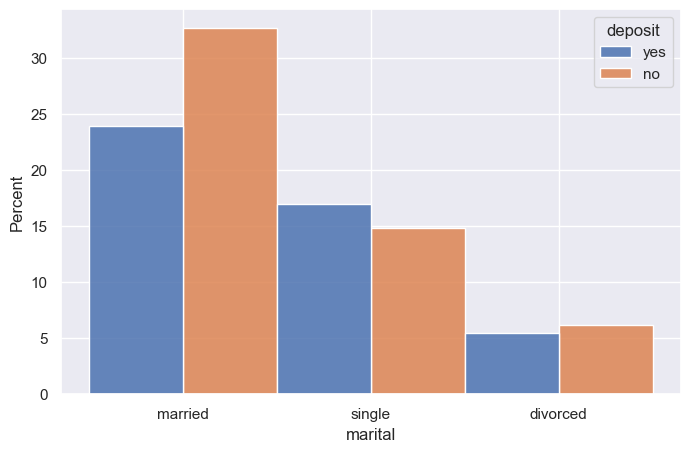

In [25]:
# визуализация для открывших и неоткрывших депозит в зависимости от семейного статуса
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(data=df, x=df['marital'], hue=df['deposit'], stat='percent', multiple='dodge', alpha=0.85);

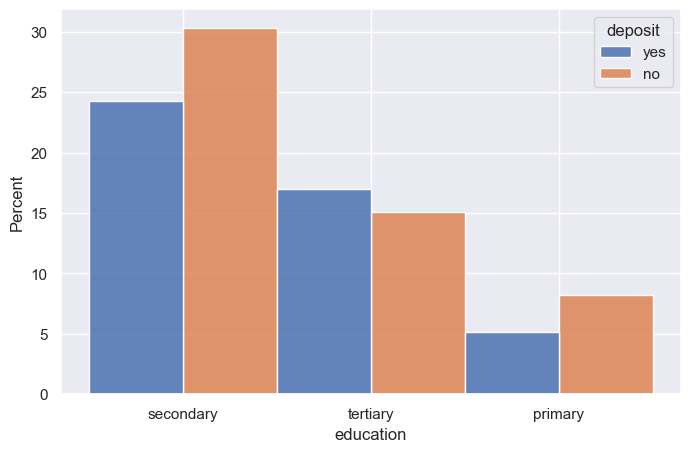

In [26]:
# визуализация для открывших и неоткрывших депозит в зависимости от образования
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(data=df, x=df['education'], hue=df['deposit'], stat='percent', multiple='dodge', alpha=0.85);

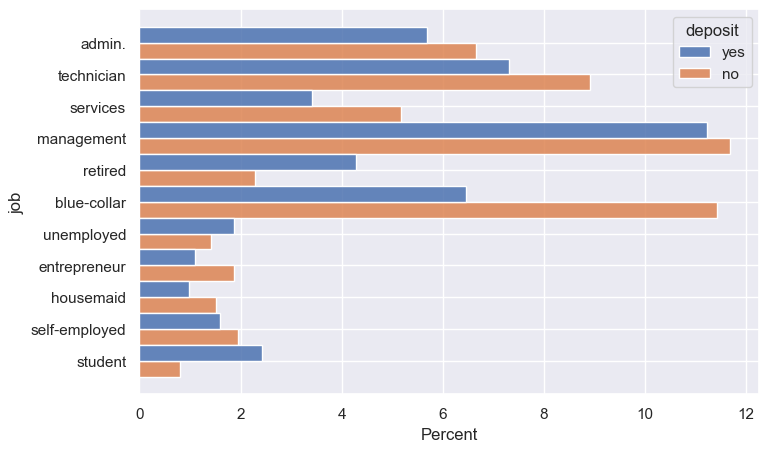

In [27]:
# визуализация для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(data=df, y=df['job'], hue=df['deposit'], stat='percent', multiple='dodge', alpha=0.85);

**Задание 3.11**  
В предыдущих заданиях мы посмотрели различные категории отдельно. Но что будет, если посмотреть на пересечения категорий? Каких людей среди открывших депозит больше: одиноких с высшим образованием или разведённых с более низким уровнем образования?

Разделите таблицу на две части: для тех, кто открыл депозит, и для тех, кто не открыл. Для каждой части постройте сводную диаграмму по уровню образования и семейному положению. Представьте результаты в виде тепловых карт. Различаются ли наиболее популярные группы для открывших депозит и для неоткрывших? Какой вывод вы можете сделать, исходя из полученных данных?

Пересечение каких двух категорий является самым многочисленным?
* Первая категория
* Вторая категория

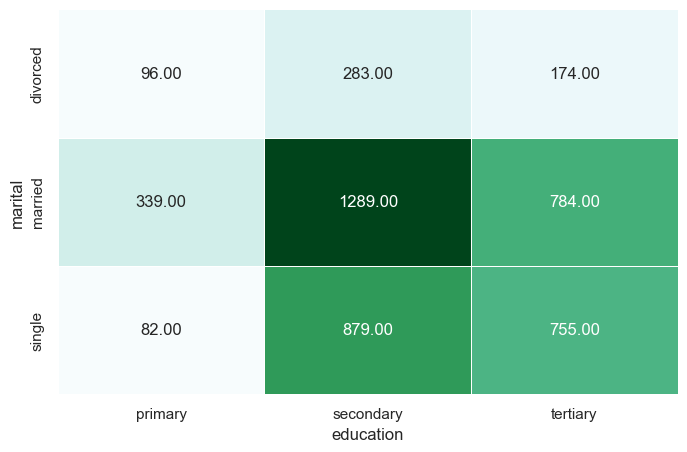

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(
    pd.pivot_table(
        df.query('`deposit` == "yes"'), 
        values='deposit', 
        index='marital', 
        columns='education', 
        aggfunc='count'
    ),
    fmt='.2f', 
    cbar=False,
    cmap="BuGn", 
    linewidths=0.5, 
    annot=True, 
    robust=True,
    ax=ax
);

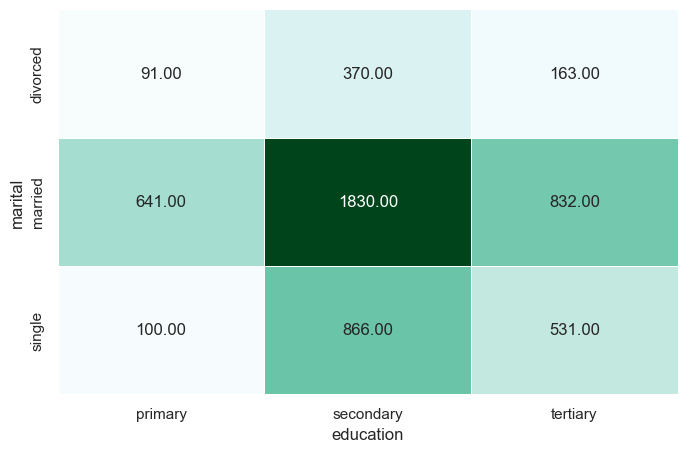

In [29]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(
    pd.pivot_table(
        df.query('`deposit` == "no"'), 
        values='deposit', 
        index='marital', 
        columns='education', 
        aggfunc='count'
    ),
    fmt='.2f', 
    cbar=False,
    cmap="BuGn", 
    linewidths=0.5, 
    annot=True, 
    robust=True,
    ax=ax
);

## Часть 3: Преобразование данных

In [30]:
# Combined column transformer for the whole dataset
# .fit method is applied to train and test data, including target variable, for exercise purposes

col_transformer = compose.ColumnTransformer([
    ('ord', preprocessing.OrdinalEncoder(), ['education', 'age_cat']),
    ('bit', preprocessing.FunctionTransformer(
        func=lambda x: np.where(x == 'yes', 1, 0), 
        feature_names_out='one-to-one'), 
        ['deposit', 'default', 'housing', 'loan']),
    ('ohe', preprocessing.OneHotEncoder(sparse_output=False), 
        ['job', 'marital', 'contact', 'month', 'poutcome'])
    ],
    remainder='passthrough'
)

print(col_transformer.fit_transform(df).shape, col_transformer.get_feature_names_out(), sep='\n')

(10105, 46)
['ord__education' 'ord__age_cat' 'bit__deposit' 'bit__default' 'bit__housing' 'bit__loan'
 'ohe__job_admin.' 'ohe__job_blue-collar' 'ohe__job_entrepreneur' 'ohe__job_housemaid'
 'ohe__job_management' 'ohe__job_retired' 'ohe__job_self-employed' 'ohe__job_services'
 'ohe__job_student' 'ohe__job_technician' 'ohe__job_unemployed' 'ohe__marital_divorced'
 'ohe__marital_married' 'ohe__marital_single' 'ohe__contact_cellular' 'ohe__contact_telephone'
 'ohe__contact_unknown' 'ohe__month_apr' 'ohe__month_aug' 'ohe__month_dec' 'ohe__month_feb'
 'ohe__month_jan' 'ohe__month_jul' 'ohe__month_jun' 'ohe__month_mar' 'ohe__month_may'
 'ohe__month_nov' 'ohe__month_oct' 'ohe__month_sep' 'ohe__poutcome_failure' 'ohe__poutcome_other'
 'ohe__poutcome_success' 'ohe__poutcome_unknown' 'remainder__age' 'remainder__balance'
 'remainder__day' 'remainder__duration' 'remainder__campaign' 'remainder__pdays'
 'remainder__previous']


**Задание 4.1**  
Начнём с обработки категориального порядкового признака, который отвечает за уровень образования: education.

Обработайте его с помощью метода LabelEncoder, используя метод без дополнительных настроек.

Найдите сумму получившихся значений для признака education.

Ранее мы создали порядковую переменную для возраста. Обработайте её по такому же принципу, чтобы её можно было использовать при обучении модели.

In [31]:
label_enc = preprocessing.OrdinalEncoder()
label_enc.fit_transform(df[['education']]).astype('int').sum()

11995

Обычно в задачах бинарной классификации целевую переменную кодируют как бинарный признак, который принимает значения 1 или 0. Так как наш проект будет соответствовать всем правилам хорошего тона, давайте перекодируем переменную deposit таким образом, чтобы вместо yes она принимала значение 1, а вместо no &mdash; 0.

Сделаем то же самое для других бинарных переменных, которых у нас три:
* 'default';
* 'housing';
* 'loan'.

Все три мы будем модифицировать ровно так же: для слова yes мы возьмём в качестве значения 1, а для no — 0.

**Задание 4.2**  
Вычислите стандартное отклонение по преобразованной в корректный вид целевой переменной deposit. Ответ округлите до трёх знаков после точки-разделителя.

**Задание 4.3**  
Вычислите среднее арифметическое для каждой из получившихся переменных, сложите три результата и в качестве ответа впишите итог, округлив его до трёх знаков после точки-разделителя.

In [32]:
binarizer = preprocessing.FunctionTransformer(func=lambda x: np.where(x == 'yes', 1, 0))
np.round(np.std(
    binarizer.transform(df[['deposit', 'default', 'housing', 'loan']])[:, 0]), 3)

0.499

In [33]:
np.round(np.sum(
    np.mean(binarizer.transform(df[['deposit', 'default', 'housing', 'loan']])[:, 1:], axis=0)), 3)

0.635

**Задание 4.4**  
Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. Это следующие переменные:
* 'job';
* 'marital';
* 'contact';
* 'month';
* 'poutcome'

Создайте для них dummy-переменные и добавьте их в набор данных.

Сколько теперь всего признаков в датасете, не считая целевую переменную? Введите ответ, посчитав уже добавленные dummy-переменные, но до удаления номинальных.

In [34]:
ohe = preprocessing.OneHotEncoder(sparse_output=False)
df.shape[1] + ohe.fit_transform(df[['job', 'marital', 'contact', 'month', 'poutcome']]).shape[1] - 1

50

Теперь давайте оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.

Для этого постройте матрицу корреляций. Дополните её тепловой картой, отражающей результат. Не забудьте, что для того, чтобы вычислить коэффициенты корреляции, необходимо, чтобы целевая переменная была числовой.

В качестве дополнения визуализации к этому заданию постройте столбчатую диаграмму для ранжированных коэффициентов корреляции.

**Задание 4.5**  
Расставьте признаки, в наибольшей степени коррелирующие с целевой переменной, по убыванию силы линейной взаимосвязи.
* poutcome_success
* duration
* contact_cellular

**Задание 4.6**  
Есть ли среди признаков мультиколлинеарность? Будем считать достаточно сильной корреляцию не менее 0.9.
* Да
* Нет

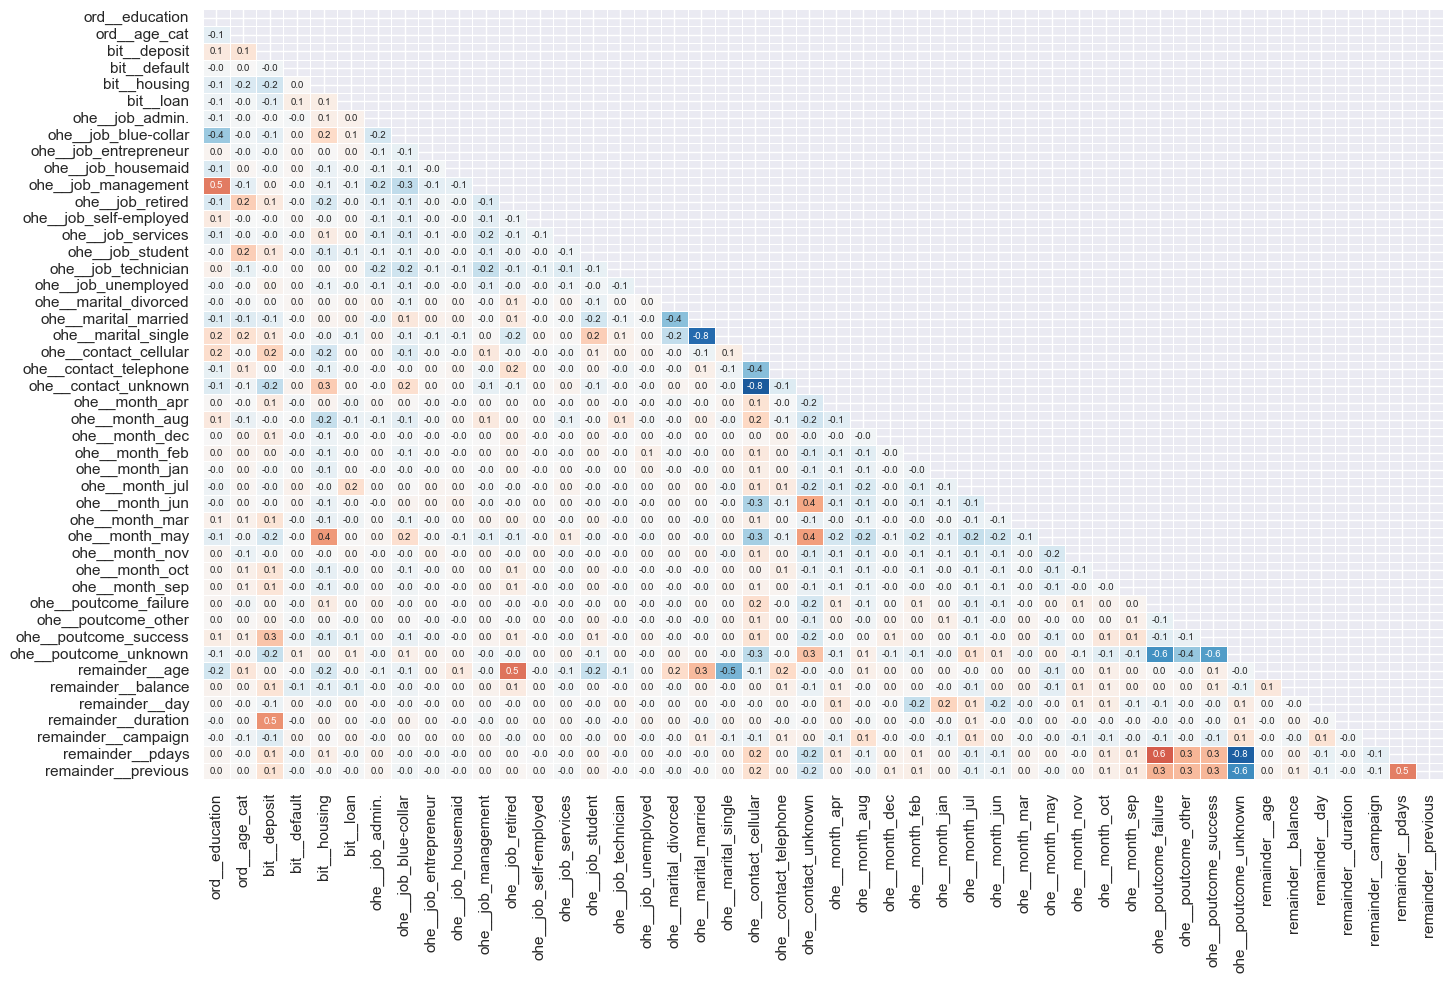

In [35]:
# duration (0.5), poutcome_sucess (0.3), contact_cellular (0.2)
df_model = pd.DataFrame(col_transformer.fit_transform(df), columns=col_transformer.get_feature_names_out())

corr_matrix = np.tril(df_model.corr(method='pearson'))
corr_matrix[corr_matrix == 0] = np.NaN
np.fill_diagonal(corr_matrix, np.NaN)

fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(
    data=corr_matrix, 
    vmin=-1, 
    vmax=1,
    fmt='.1f', 
    cbar=False,
    cmap="RdBu_r", 
    linewidths=0.5, 
    annot=True, 
    annot_kws={'fontsize':'xx-small'},
    xticklabels=df_model.columns,
    yticklabels=df_model.columns,
    robust=True,
    ax=ax
);

Теперь вам необходимо определить целевую переменную и предикторы, а также разделить выборку на обучающую и тестовую.

При разбиении задайте параметр random_state = 42, а размер тестовой выборки возьмите за 0.33. Не забудьте добавить аргумент, определяющий сохранение соотношений целевого признака.

**Задание 4.7**  
Каким получился размер тестовой выборки?

**Задание 4.8**  
Каково среднее значение целевой переменной на тестовой выборке? Ответ округлите до двух знаков после точки-разделителя.

In [36]:
X = df_model.drop(columns='bit__deposit')
y = df_model['bit__deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

In [37]:
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}, y_test: {y_test.shape}')

X_train: (6770, 45), X_test: (3335, 45)
y_train: (6770,), y_test: (3335,)


In [38]:
np.round(np.mean(y_test), 2)

0.46

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью SelectKBest отберите 15 признаков, наилучшим образом подходящих для использования в задаче. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_classif.

Помните, что на данном этапе вам необходимо оставить только те признаки, которые содержат лишь числовые значения.

**Задание 4.9**  
Укажите одну переменную, не попавшую в данный перечень:
* month_mar
* month_may
* month_oct
* month_sep
* month_jan

In [39]:
pipe_1 = pipeline.Pipeline([
    ('top15', SelectKBest(score_func=f_classif, k=15))
])

In [40]:
pipe_1.fit(X_train, y_train)
pipe_1.get_feature_names_out()

array(['ord__age_cat', 'bit__housing', 'ohe__contact_cellular', 'ohe__contact_unknown',
       'ohe__month_mar', 'ohe__month_may', 'ohe__month_oct', 'ohe__month_sep',
       'ohe__poutcome_success', 'ohe__poutcome_unknown', 'remainder__balance',
       'remainder__duration', 'remainder__campaign', 'remainder__pdays', 'remainder__previous'],
      dtype=object)

Теперь данные необходимо нормализовать.

Есть разные варианты нормализации, но мы будем использовать min-max-нормализацию.

Помните, что нормализация требуется для предикторов, а не для целевой переменной.

Нормализуйте предикторы в обучающей и тестовой выборках.

**Задание 4.10**  
Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки. Ответ округлите до двух знаков после точки-разделителя.

In [41]:
pipe_2 = pipeline.Pipeline([
    ('top15', SelectKBest(score_func=f_classif, k=15)),
    ('scaler', preprocessing.MinMaxScaler())
])

In [42]:
# the correct answer is 0.47 for variable remainder__balance
pipe_2.fit(X_train, y_train)
{k:v for k, v in zip(pipe_2['top15'].get_feature_names_out(), 
    np.round(np.mean(pipe_2.transform(X_test), axis=0), 2))}

{'ord__age_cat': 0.34,
 'bit__housing': 0.48,
 'ohe__contact_cellular': 0.72,
 'ohe__contact_unknown': 0.21,
 'ohe__month_mar': 0.02,
 'ohe__month_may': 0.25,
 'ohe__month_oct': 0.03,
 'ohe__month_sep': 0.03,
 'ohe__poutcome_success': 0.1,
 'ohe__poutcome_unknown': 0.74,
 'remainder__balance': 0.47,
 'remainder__duration': 0.09,
 'remainder__campaign': 0.04,
 'remainder__pdays': 0.06,
 'remainder__previous': 0.01}

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

Для начала реализуем самый простой алгоритм, который вам известен — логистическую регрессию. В качестве алгоритма оптимизации будем использовать 'sag', в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций.

Оцените качество модели на тестовой выборке.

**Задание 5.1**  
Для получившейся модели вычислите значение accuracy на тестовой выборке. Ответ округлите до двух знаков после точки-разделителя.

In [43]:
pipe_3 = pipeline.Pipeline([
    ('top15', SelectKBest(score_func=f_classif, k=15)),
    ('scaler', preprocessing.MinMaxScaler()),
    ('log_reg', linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42))
])

In [44]:
# accuracy = 0.81
pipe_3.fit(X_train, y_train)
print(metrics.classification_report(y_test, pipe_3.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.79      0.87      0.83      1790
         1.0       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



Простой алгоритм обучен. Теперь давайте обучим ещё один алгоритм &mdash; решающие деревья. В качестве параметров для начала возьмём следующие:
* criterion = 'entropy';
* random_state = 42.

Остальные параметры оставьте по умолчанию.

**Задание 5.2**  
Что можно наблюдать после реализации алгоритма и оценки его качества?
* Недообучение
* Переобучение
* Утечку данных

In [45]:
pipe_4 = pipeline.Pipeline([
    ('top15', SelectKBest(score_func=f_classif, k=15)),
    ('scaler', preprocessing.MinMaxScaler()),
    ('dtc', tree.DecisionTreeClassifier(criterion='entropy', random_state=42))
])

In [46]:
pipe_4.fit(X_train, y_train)
print(metrics.classification_report(y_train, pipe_4.predict(X_train)))
print(metrics.classification_report(y_test, pipe_4.predict(X_test)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3634
         1.0       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

              precision    recall  f1-score   support

         0.0       0.76      0.77      0.76      1790
         1.0       0.73      0.71      0.72      1545

    accuracy                           0.74      3335
   macro avg       0.74      0.74      0.74      3335
weighted avg       0.74      0.74      0.74      3335



Переберите различные максимальные глубины деревьев и найдите глубину дерева, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой).

**Задание 5.3**  
Какое наибольшее значение accuracy у вас получилось? Ответ округлите до двух знаков после точки-разделителя.

**Задание 5.4**  
Какую максимальную глубину дерева вы задали?

In [47]:
# accuracy = 0.81, max_depth = 6
maxdepth_param = {'dtc__max_depth': np.arange(1, 26)}

pipe_4_grid = GridSearchCV(pipe_4, maxdepth_param, scoring='accuracy', 
    cv=5, return_train_score=True, verbose=1, n_jobs=-1)
pipe_4_grid.fit(X_train, y_train);

Fitting 5 folds for each of 25 candidates, totalling 125 fits


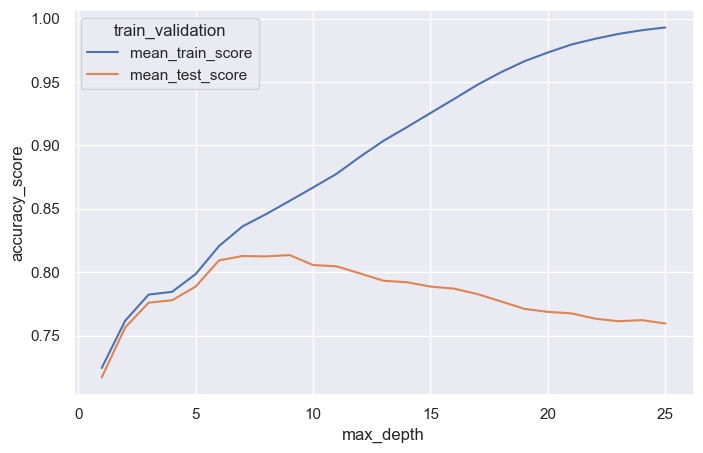

In [48]:
df_tmp = pd.DataFrame(pipe_4_grid.cv_results_).loc[:, ['param_dtc__max_depth', 'mean_train_score', 'mean_test_score']]
df_tmp = pd.DataFrame(df_tmp.set_index('param_dtc__max_depth').stack(), 
    columns=['accuracy_score']).reset_index(names=['max_depth', 'train_validation'])

fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=df_tmp, x='max_depth', y='accuracy_score', hue='train_validation', ax=ax);

Разумеется, у каждой модели может быть множество параметров. Перебирать их вручную, чтобы получить наилучшее качество, долго и трудозатратно. Поэтому мы можем использовать оптимизацию: можно перебрать сразу большое количество комбинаций различных параметров и выбрать тот вариант, при котором модель будет давать наиболее точный прогноз.

Реализуйте оптимизацию гиперпараметров с помощью GridSearch, перебрав следующие параметры:
* 'min_samples_split': [2, 5, 7, 10];
* 'max_depth' :[3, 5, 7].

**Задание 5.5**  
Оцените метрику F1 на тестовой выборке для наилучшей комбинации перебираемых параметров. В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.

In [49]:
# F1 score = 0.79
maxdepth_param = {'dtc__max_depth': [3, 5, 7], 'dtc__min_samples_split': [2, 5, 7, 10]}

pipe_4_grid = GridSearchCV(pipe_4, maxdepth_param, scoring='f1', 
    cv=5, return_train_score=True, verbose=1, n_jobs=-1)
pipe_4_grid.fit(X_train, y_train);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [50]:
(pd.DataFrame(pipe_4_grid.cv_results_)
    .loc[:, ['rank_test_score', 'param_dtc__max_depth', 'param_dtc__min_samples_split', 'mean_train_score', 'mean_test_score']]
    .sort_values(by=['rank_test_score', 'mean_test_score'], ascending=[True, False])
    .head(3)
)

rank_test_score param_dtc__max_depth param_dtc__min_samples_split  \
11                1                    7                           10   
10                2                    7                            7   
9                 3                    7                            5   

    mean_train_score  mean_test_score  
11            0.8187           0.7961  
10            0.8195           0.7959  
9             0.8201           0.7955

In [51]:
print(metrics.classification_report(y_test, pipe_4_grid.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83      1790
         1.0       0.79      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

Обучите случайный лес со следующими параметрами:
* n_estimators = 100;
* criterion = 'gini';
* min_samples_leaf = 5;
* max_depth = 10;
* random_state = 42.

**Задание 6.1**  
Оцените метрики accuracy и recall для построенной модели на тестовой выборке. В качестве ответов введите значения метрик. Ответ округлите до двух знаков после точки-разделителя.
* Accuracy
* Recall

In [52]:
# accuracy = 0.83, recall = 0.84
pipe_5 = pipeline.Pipeline([
    ('top15', SelectKBest(score_func=f_classif, k=15)),
    ('scaler', preprocessing.MinMaxScaler()),
    ('rf', ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', 
        min_samples_leaf=5, max_depth=10, random_state=42))
])

In [53]:
pipe_5.fit(X_train, y_train)
print(metrics.classification_report(y_test, pipe_5.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.85      0.82      0.83      1790
         1.0       0.80      0.83      0.81      1545

    accuracy                           0.83      3335
   macro avg       0.82      0.83      0.82      3335
weighted avg       0.83      0.83      0.83      3335



Дата-сайентист не должен останавливаться на одной модели &mdash; он должен пробовать все доступные варианты. Поэтому теперь предлагаем вам сравнить полученные результаты с моделью градиентного бустинга. Используйте градиентный бустинг для решения задачи классификации, задав для него следующие параметры:
* learning_rate = 0.05;
* n_estimators = 300;
* min_samples_leaf = 5;
* max_depth = 5;
* random_state = 42.

**Задание 6.2**  
Для построенной модели оцените метрику F1 на тестовой выборке. В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.

**Задание 6.3**  
Какая модель даёт более качественный прогноз (если посмотреть известные вам метрики в целом)?
* Случайный лес
* Градиентный бустинг

In [54]:
# F1 score = 0.82
pipe_6 = pipeline.Pipeline([
    ('top15', SelectKBest(score_func=f_classif, k=15)),
    ('scaler', preprocessing.MinMaxScaler()),
    ('gbc', ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, 
        min_samples_leaf=5, max_depth=5, random_state=42))
])

In [55]:
pipe_6.fit(X_train, y_train)
print(metrics.classification_report(y_test, pipe_6.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.85      0.82      0.84      1790
         1.0       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Вы уже попробовали построить разные модели, и теперь пришло время построить ансамбль из моделей разного типа.

В этом задании вам необходимо использовать стекинг, объединив те алгоритмы, которые вы уже использовали ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используйте модель логистической регрессии.

Параметры оставьте те же, что были в ваших алгоритмах в предыдущих заданиях.

**Задание 6.4**  
Для построенной модели оцените метрику precision на тестовой выборке. В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.

In [56]:
# precision = 0.82
estimators = [
    ('dtc', tree.DecisionTreeClassifier(criterion='entropy', random_state=42)),
    ('log_reg', linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)),
    ('gbc', ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, 
        min_samples_leaf=5, max_depth=5, random_state=42))
]

pipe_7 = pipeline.Pipeline([
    ('top15', SelectKBest(score_func=f_classif, k=15)),
    ('scaler', preprocessing.MinMaxScaler()),
    ('model', ensemble.StackingClassifier(estimators=estimators, 
        final_estimator=linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)))
])

In [57]:
pipe_7.fit(X_train, y_train)
print(metrics.classification_report(y_test, pipe_7.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.84      0.83      0.83      1790
         1.0       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Разумеется, не все признаки одинаково хорошо предсказывают результат маркетинговой кампании. Для того чтобы отобрать наиболее значимые для нас аспекты, на которые надо будет обратить внимание при реализации следующей акции, давайте выберем три признака, дающих наибольший вклад.

Почему, с вашей точки зрения, именно эти три признака имеют наибольшую важность?

**Задание 6.5**  
Расставьте признаки по убыванию их важности.
* contact_unknown
* duration
* poutcome_success

In [58]:
# duration, poutcome_success, contact_unknown
pipe_7 = pipeline.Pipeline([
    ('top15', SelectKBest(score_func=f_classif, k=15)),
    ('scaler', preprocessing.MinMaxScaler()),
    ('rfe', RFE(ensemble.GradientBoostingClassifier(), n_features_to_select=3))
])

In [59]:
pipe_7.fit(X_train, y_train)
pipe_7.get_feature_names_out()

array(['ohe__contact_unknown', 'ohe__poutcome_success', 'remainder__duration'], dtype=object)

Ранее мы уже рассматривали оптимизацию гиперпараметров при помощи GridSearch. Однако вы знаете, что это не единственный способ. Один из более продвинутых вариантов оптимизации гиперпараметров — фреймворк Optuna. Примените его для оптимизации гиперпараметров. Для перебора возьмите случайный лес и следующие параметры:
* n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
* max_depth = trial.suggest_int('max_depth', 10, 30, 1);
* min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1).

**Задание 6.6**  
Введите значение метрики F1 на тестовой выборке. Ответ округлите до двух знаков после точки-разделителя.

**Задание 6.7**  
Введите значение метрики accuracy на тестовой выборке. Ответ округлите до двух знаков после точки-разделителя.

**Задание 6.8**  
Улучшился ли результат по сравнению с предыдущими моделями?
* Да
* Нет

In [60]:
# F1 score = 0.83, accuracy = 0.84
def optuna_grid(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    model = pipeline.Pipeline([
        ('top15', SelectKBest(score_func=f_classif, k=15)),
        ('scaler', preprocessing.MinMaxScaler()),
        ('rf', ensemble.RandomForestClassifier(
                n_estimators=n_estimators, 
                criterion='gini', 
                min_samples_leaf=min_samples_leaf, 
                max_depth=max_depth, 
                random_state=42
            )
        )
    ])

    score = cross_val_score(model, X_train, y_train, 
        cv=5, scoring="f1", n_jobs=-1, verbose=0).mean()
    return score

model_optuna = optuna.create_study(study_name="optuna_optimize", direction="maximize")
model_optuna.optimize(optuna_grid, n_trials=10)

[I 2023-08-12 12:02:56,829] A new study created in memory with name: optuna_optimize
[I 2023-08-12 12:03:02,494] Trial 0 finished with value: 0.8261778687761042 and parameters: {'n_estimators': 162, 'max_depth': 25, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8261778687761042.
[I 2023-08-12 12:03:05,022] Trial 1 finished with value: 0.8239910982781169 and parameters: {'n_estimators': 107, 'max_depth': 29, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8261778687761042.
[I 2023-08-12 12:03:08,137] Trial 2 finished with value: 0.8262794787199563 and parameters: {'n_estimators': 126, 'max_depth': 16, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8262794787199563.
[I 2023-08-12 12:03:11,383] Trial 3 finished with value: 0.8239580067397002 and parameters: {'n_estimators': 143, 'max_depth': 26, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8262794787199563.
[I 2023-08-12 12:03:15,300] Trial 4 finished with value: 0.8231456780978362 and parameters: {'n_estimat

In [61]:
pipe_8 = pipeline.Pipeline([
        ('top15', SelectKBest(score_func=f_classif, k=15)),
        ('scaler', preprocessing.MinMaxScaler()),
        ('rf', ensemble.RandomForestClassifier(
                n_estimators=model_optuna.best_trial.params['n_estimators'], 
                criterion='gini', 
                min_samples_leaf=model_optuna.best_trial.params['min_samples_leaf'], 
                max_depth=model_optuna.best_trial.params['max_depth'], 
                random_state=42
            )
        )
    ])

In [62]:
pipe_8.fit(X_train, y_train)
print(metrics.classification_report(y_test, pipe_8.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84      1790
         1.0       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

